# TCP Congestion Control NS2 Analysis
## Arman Rostami, Parsa Ghorbani

### Topology Implementation Assumptions

1. We used ftp to transfer packets and assigned them to nodes 1 and 2 as agents.
2. To implement router queue limits we assigned queue limit to each of routers output links.

### Initialization

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
SIMULATION_COUNT = 10
SIMULATION_TIME = 1000
TCL_FILENAME = "congestion.tcl"
TRACE_FILENAME = "congestion.tr"
OUTPUT_ENDING = ".csv"
CWND_DATA_NAME = "cwnd"
GOODPUT_DATA_NAME = "goodput"
DROP_METHOD_1_DATA_NAME = "drop_method_1"
DROP_METHOD_2_DATA_NAME = "drop_method_2"
RTT_DATA_NAME = "rtt"

In [3]:
plt.rcParams["figure.figsize"] = (14, 5) 

### Tools

In [4]:
class Tools:
    def plot_data(self, data_1, data_2):
        plt.plot(data_1, "b", label="Top flow")
        plt.plot(data_2, "r", label="Bottom flow")
        plt.xlabel("time")
        plt.ylabel(data_1.name)
        plt.legend()
        
    def read_file(self, filename):
        with open(filename) as input_file:
            file_content = input_file.readlines()
            file_content = [x.split() for x in file_content]
            return file_content

### Simulator

In [5]:
class Simulator:
    def __init__(self, congestion_algorithm):
        self.congestion_algorithm = congestion_algorithm
        self.tools = Tools()
        self.data = {}

In [6]:
def train(self):
    for i in range(0, SIMULATION_COUNT):
        os.system("ns " + TCL_FILENAME + " " + self.congestion_algorithm)
        self.update_data(i, CWND_DATA_NAME)
        self.update_data(i, GOODPUT_DATA_NAME)
        self.update_data(i, DROP_METHOD_1_DATA_NAME)
        self.update_data(i, DROP_METHOD_2_DATA_NAME)
        self.update_data(i, RTT_DATA_NAME)
        
Simulator.train = train

In [7]:
def get_dict_key(self, data_name, index):
    return data_name + "_" + str(index)

Simulator.get_dict_key = get_dict_key

In [8]:
def read_updated_data(self, data_name):
    if data_name == DROP_METHOD_1_DATA_NAME:
        new_data_1 = self.get_drop_rates_method_1("1")
        new_data_2 = self.get_drop_rates_method_1("2")
    elif data_name == DROP_METHOD_2_DATA_NAME:
        new_data_1 = self.get_drop_rates_method_2("1")
        new_data_2 = self.get_drop_rates_method_2("2")
    else:
        new_data_1 = pd.read_csv(data_name + "1" + OUTPUT_ENDING)
        new_data_2 = pd.read_csv(data_name + "2" + OUTPUT_ENDING)
        
    return new_data_1, new_data_2

Simulator.read_updated_data = read_updated_data

In [9]:
def update_data(self, simulation_index, data_name):
    new_data_1, new_data_2 = self.read_updated_data(data_name)
        
    data_dict_key_1 = self.get_dict_key(data_name, 1)
    data_dict_key_2 = self.get_dict_key(data_name, 2)
    
    if simulation_index == 0:
        self.data[data_dict_key_1] = new_data_1[data_name]
        self.data[data_dict_key_2] = new_data_2[data_name]
    else:
        self.data[data_dict_key_1] += new_data_1[data_name]
        self.data[data_dict_key_2] += new_data_2[data_name]
        
    if simulation_index == SIMULATION_COUNT - 1:
        self.data[data_dict_key_1] /= SIMULATION_COUNT
        self.data[data_dict_key_2] /= SIMULATION_COUNT
    
Simulator.update_data = update_data

In [10]:
def plot_data(self, data_name):
    data_1 = self.data[self.get_dict_key(data_name, 1)]
    data_2 = self.data[self.get_dict_key(data_name, 2)]
    self.tools.plot_data(data_1, data_2)
    
Simulator.plot_data = plot_data

In [11]:
def get_drop_rates_method_1(self, flow_id):
    drop_rates = [0] * SIMULATION_TIME
    
    trace_file = self.tools.read_file(TRACE_FILENAME)
    
    for trace_line in trace_file:
        if trace_line[0] == 'd' and trace_line[7] == flow_id:
            time_index = int(float(trace_line[1]))
            drop_rates[time_index] += 1
    
    return pd.DataFrame(drop_rates, columns=[DROP_METHOD_1_DATA_NAME])

Simulator.get_drop_rates_method_1 = get_drop_rates_method_1

In [12]:
from __future__ import division

def get_drop_rates_method_2(self, flow_id):
    drop_counts, number_of_acks = self.get_drop_rate_info(flow_id)
    
    number_of_acks_per_second = [1] * SIMULATION_TIME
    for i in range(1, SIMULATION_TIME):
        number_of_acks_per_second[i] = max(1, number_of_acks[i] - number_of_acks[i - 1])
    
    drop_rates = [x / y for x, y in zip(drop_counts, number_of_acks_per_second)]
    
    return pd.DataFrame(drop_rates, columns=[DROP_METHOD_2_DATA_NAME])

Simulator.get_drop_rates_method_2 = get_drop_rates_method_2

In [13]:
def get_drop_rate_info(self, flow_id):
    drop_counts = [0] * SIMULATION_TIME
    number_of_acks = [0] * SIMULATION_TIME
    
    trace_file = self.tools.read_file(TRACE_FILENAME)
    
    for trace_line in trace_file:
        if trace_line[7] == flow_id:
            time_index = int(float(trace_line[1]))
            if trace_line[0] == 'd':
                drop_counts[time_index] += 1
            elif trace_line[0] == 'r' and trace_line[4] == "ack":
                number_of_acks[time_index] = max(number_of_acks[time_index], int(trace_line[10]))
    
    return drop_counts, number_of_acks

Simulator.get_drop_rate_info = get_drop_rate_info

### Train Simulators

In [14]:
new_reno_simulator = Simulator("Newreno")
new_reno_simulator.train()

In [15]:
tahoe_simulator = Simulator("Tahoe")
tahoe_simulator.train()

In [16]:
vegas_simulator = Simulator("Vegas")
vegas_simulator.train()

### CWND

***Assumption:*** Congestion window size is sampled in each second.

#### CWND: Newreno

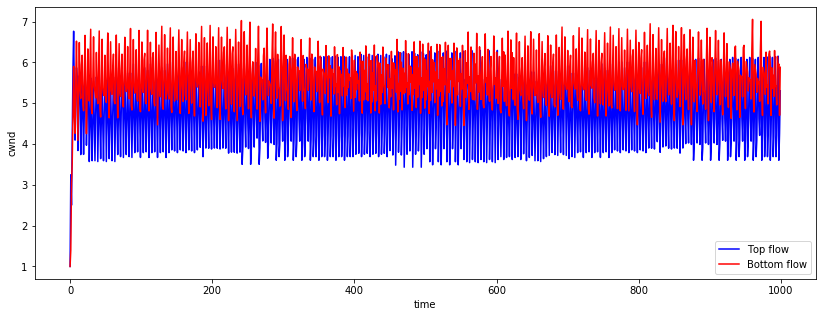

In [17]:
new_reno_simulator.plot_data(CWND_DATA_NAME)

#### CWND: Tahoe

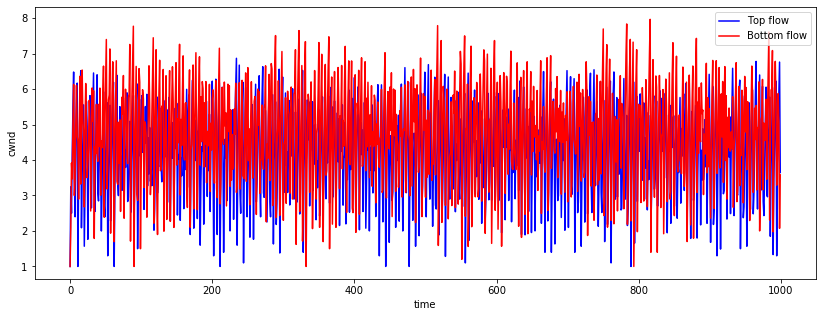

In [18]:
tahoe_simulator.plot_data(CWND_DATA_NAME)

#### CWND: Vegas

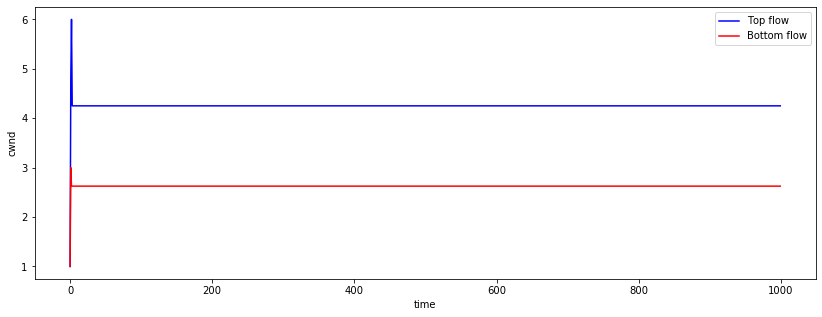

In [19]:
vegas_simulator.plot_data(CWND_DATA_NAME)

### Goodput

***Assumption:*** Goodput rate is measured as number of acknowledged bits received in each second time interval.

#### Goodput: Newreno

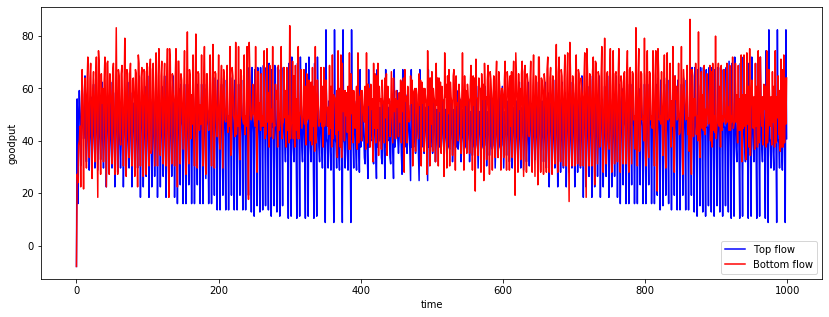

In [20]:
new_reno_simulator.plot_data(GOODPUT_DATA_NAME)

#### Goodput: Tahoe

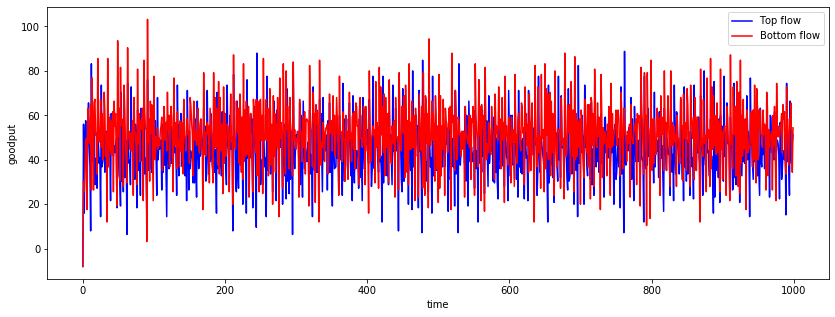

In [21]:
tahoe_simulator.plot_data(GOODPUT_DATA_NAME)

#### Goodput: Vegas

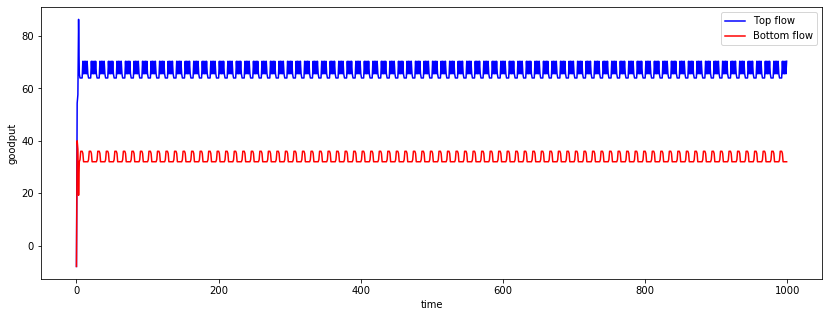

In [22]:
vegas_simulator.plot_data(GOODPUT_DATA_NAME)

### Drop Rate

***Assumptions:*** Due to ambiguity of drop rate definition two methods to measure drop rate is implemented.

**Method 1**: In this method drop rate is measured as number of drops in each second time interval.

#### Drop Rate Method 1: Newreno

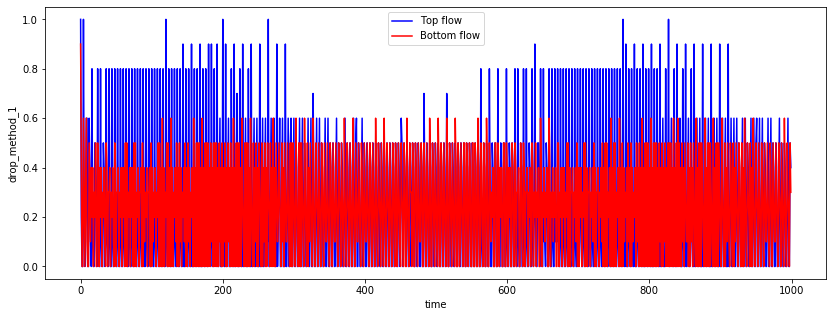

In [23]:
new_reno_simulator.plot_data(DROP_METHOD_1_DATA_NAME)

#### Drop Rate Method 1: Tahoe

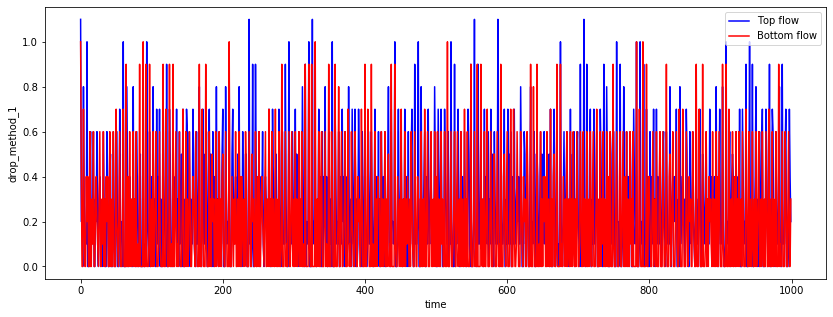

In [24]:
tahoe_simulator.plot_data(DROP_METHOD_1_DATA_NAME)

#### Drop Rate Method 1: Vegas

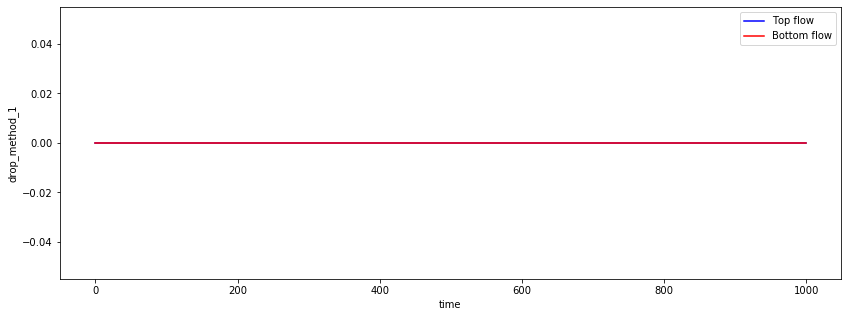

In [25]:
vegas_simulator.plot_data(DROP_METHOD_1_DATA_NAME)

**Method 2**: This method is based on description on [this website](http://intronetworks.cs.luc.edu/current/html/ns2.html#loss-rate-versus-cwnd-part-1). In this method, drop rate is calculated as number of packets dropped divided by number of packets acknowledged in each second time interval.

#### Drop Rate Method 2: Newreno

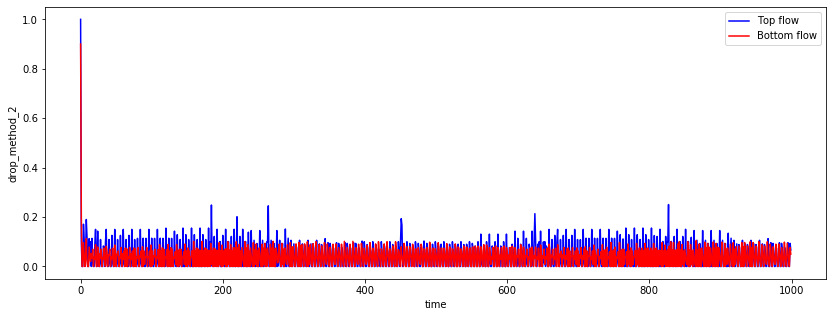

In [26]:
new_reno_simulator.plot_data(DROP_METHOD_2_DATA_NAME)

#### Drop Rate Method 2: Tahoe

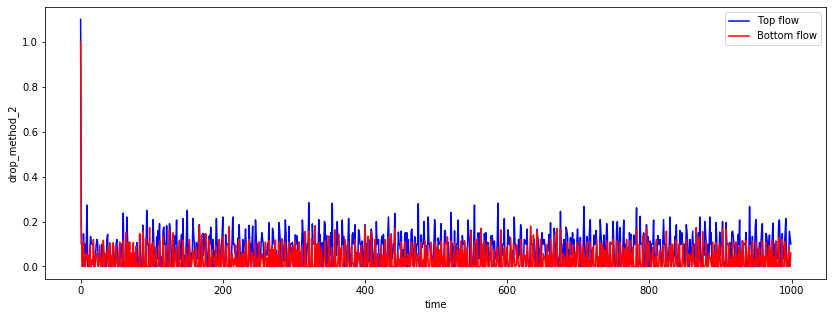

In [27]:
tahoe_simulator.plot_data(DROP_METHOD_2_DATA_NAME)

#### Drop Rate Method 2: Vegas

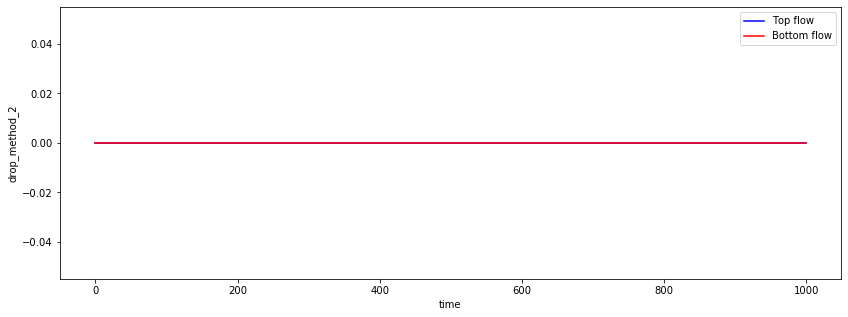

In [28]:
vegas_simulator.plot_data(DROP_METHOD_2_DATA_NAME)

### RTT

***Assumption***: RTT is measured as current RTT in flow using flow's rtt field in ns2 in each second.

#### RTT: Newreno

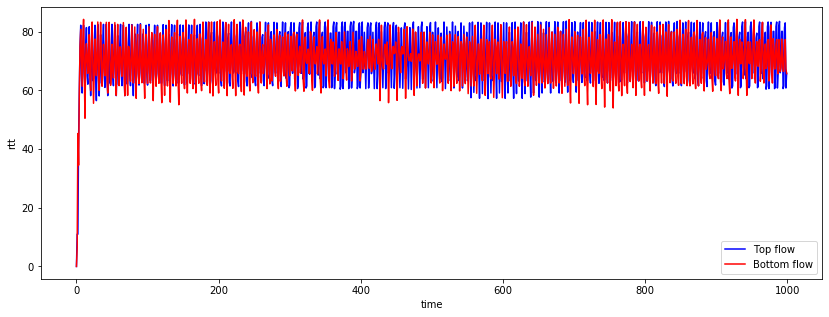

In [29]:
new_reno_simulator.plot_data(RTT_DATA_NAME)

#### RTT: Tahoe

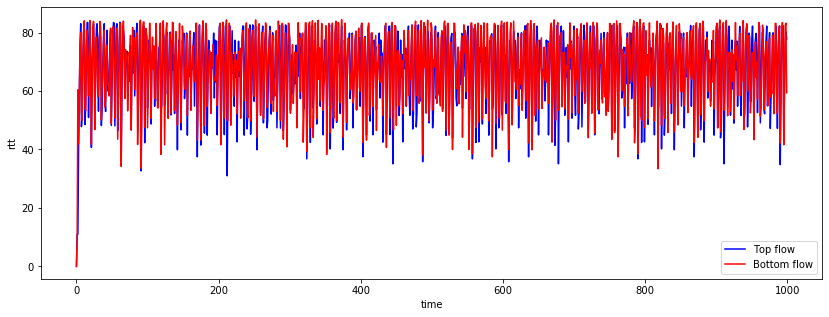

In [30]:
tahoe_simulator.plot_data(RTT_DATA_NAME)

#### RTT: Vegas

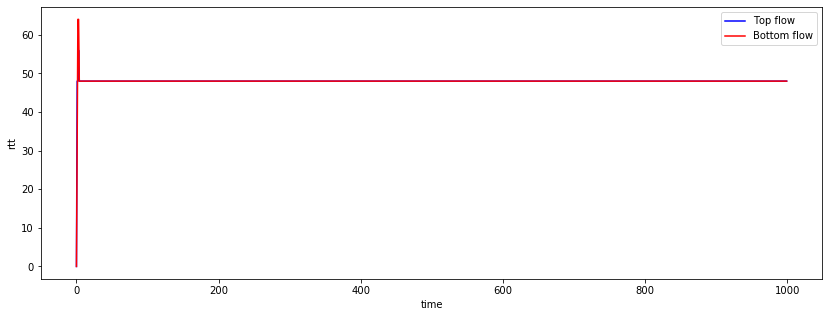

In [31]:
vegas_simulator.plot_data(RTT_DATA_NAME)